In [ ]:
!pip install requests --quiet

Data retrieval and procesing

In [6]:
import json
import requests
import pandas as pd

# ReliefWeb API endpoint
url = "https://api.reliefweb.int/v1/disasters"

# ICPAC countries
icpac_countries = [
    "Burundi", "Djibouti", "Eritrea", "Ethiopia", "Kenya", "Rwanda",
    "Somalia", "South Sudan", "Sudan", "Uganda", "Tanzania"
]

# Prepare the payload for the POST request
payload = {
    "filter": {"operator": "OR", "conditions": []},
    "fields": {"include": ["id", "name", "country", "date", "description", "type"]},
    "limit": 100,
    "sort": ["date:desc"]
}

# Add conditions for each country
for country in icpac_countries:
    payload["filter"]["conditions"].append({"field": "country.name", "value": country})

headers = {"Content-Type": "application/json", "Accept": "application/json"}

# POST request
response = requests.post(url, headers=headers, json=payload, timeout=60)

# Check response status
if response.status_code == 200:
    disaster_data = response.json()
    disasters = disaster_data.get("data", [])

    # Extract and process the data
    data_list = []
    for disaster in disasters:
        fields = disaster["fields"]
        description = fields.get("description", "Data not available")
        country_info = fields.get("country", [{"name": "N/A"}])[0]
        country_name = country_info.get("name", "N/A")
        # Extract coordinates from the country field
        coordinates = country_info.get("location", {}).get("geometry", {}).get("coordinates", [])
        latitude = coordinates[1] if len(coordinates) > 1 else "N/A"
        longitude = coordinates[0] if coordinates else "N/A"
        data = {
            "id": fields.get("id", "N/A"),
            "name": fields.get("name", "N/A"),
            "country": country_name,
            "date": fields.get("date", "N/A"),
            "description": description,

        }
        data_list.append(data)

    # Convert to DataFrame
    df = pd.DataFrame(data_list)
    df.to_csv('disasters_data.csv', index=False)
else:
    print("Failed to retrieve data. Status code:", response.status_code)
    print("Response Content:", response.content)


In [48]:
import pandas as pd
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Function to tokenize text and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    tokens = [token.strip() for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Function to extract common words from descriptions
def extract_common_words(df):
    all_descriptions = ' '.join(df['description'])
    tokens = tokenize_and_remove_stopwords(all_descriptions)
    word_freq = Counter(tokens)
    common_words = [word for word, _ in word_freq.most_common(20)]
    return common_words

# Function for feature engineering and splitting
def feature_engineering(df):
    try:
        # Check and preprocess date column
        if not pd.api.types.is_string_dtype(df['date']):
            df['date'] = df['date'].astype(str)

        # Handle NaN values if any
        df['date'].fillna('', inplace=True)

        # Preprocess date column to ensure valid JSON format
        df['date'] = df['date'].str.replace("'", '"')
        df['date'] = df['date'].apply(lambda x: json.loads(x))

        # Convert date strings to datetime format
        def extract_changed_date(x):
            if 'changed' in x:
                return x['changed']
            else:
                return None

        df['date_changed'] = pd.to_datetime(df['date'].apply(extract_changed_date), errors='coerce')

        # Example of hypothetical feature engineering
        df['people_count'] = df['description'].apply(lambda x: x.lower().count('people'))
        df['cases_count'] = df['description'].apply(lambda x: x.lower().count('cases'))
        df['deaths_count'] = df['description'].apply(lambda x: x.lower().count('deaths'))

        # Select relevant features for processing
        df_processed = df[['country', 'description', 'people_count', 'cases_count', 'deaths_count']]
        df_to_save = df.drop(columns=['date', 'description']).copy()

        return df_processed, df_to_save

    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None, None

# Example usage
# Assuming df is your DataFrame
df_processed, df_to_save = feature_engineering(df)

if df_processed is not None and df_to_save is not None:
    # Save to CSV
    df_processed.to_csv('processed_data.csv', index=False)
    df_to_save.to_csv('data_to_save.csv', index=False)
else:
    print("Error occurred during feature engineering, check logs for details.")


In [49]:
print("Columns in disasters_df:", disasters_df.columns)
print("Columns in processed_df:", processed_df.columns)

Columns in disasters_df: Index(['id', 'name', 'country', 'date', 'description'], dtype='object')
Columns in processed_df: Index(['country', 'date_changed', 'description', 'people_count', 'cases_count',
       'deaths_count'],
      dtype='object')


In [110]:
data = {
    'name': [
        'Ethiopia: Floods - May 2024', 'Uganda: Floods - May 2024', 'Rwanda: Floods - Apr 2024',
        'Tanzania: Floods - Apr 2024', 'Somalia: Floods - Apr 2024', 'Kenya: Floods - Apr 2024',
        'South Sudan: Hepatitis E Outbreak - Sep 2023', 'Uganda: Anthrax Outbreak - Nov 2023',
        'Burundi: Floods and Landslides - Oct 2023', 'Tanzania: Floods - Nov 2023',
        'Tanzania: Cholera Outbreak - Jul 2023', 'Ethiopia: Floods - Nov 2023',
        'Kenya: Floods - Oct 2023', 'Sudan: Floods - Sep 2023', 'Somalia: Floods - Oct 2023',
        'Sudan: Cholera Outbreak - Sep 2023', 'Rwanda: Floods and Landslides - May 2023',
        'Tanzania: Floods - Apr 2023', 'Kenya: Floods - Mar 2023', 'Ethiopia: Floods - Mar 2023',
        'South Sudan: Measles - Dec 2022', 'Tanzania: Marburg Virus Disease Outbreak - Mar 2023',
        'Somalia: Floods - Mar 2023', 'Burundi: Cholera Outbreak - Jan 2023',
        'Kenya: Cholera Outbreak - Oct 2022', 'Ethiopia: Floods - Jul 2022',
        'Ethiopia: Cholera Outbreak - Sep 2022', 'Uganda: Ebola Outbreak - Sep 2022',
        'Chad: Floods - Jul 2022', 'Uganda: Floods - Jul 2022', 'Sudan: Floods - Jun 2022',
        'Somalia: Rain and Windstorms - May 2022', 'South Sudan: Cholera Outbreak - May 2022',
        'Tanzania: Cholera Outbreak - Apr 2022', 'Somalia: Urban Fire Incident - Apr 2022',
        'Djibouti: Drought - Mar 2022', 'Sudan: Kala-azar Outbreak - Feb 2022',
        'Kenya: Yellow Fever and Chikungunya Outbreaks - Jan 2022', 'Uganda: Floods and Landslides - Sep 2021',
        'Sudan: Floods - Jul 2021', 'South Sudan: Floods 2021-2022', 'Somalia: Floods - May 2021',
        'Rwanda: Floods and Windstorm - Apr 2021', 'Tropical Storm Jobo - Apr 2021', 'Burundi: Floods - Apr 2021',
        'Kenya: Floods - Apr 2021', 'Kenya: Dengue Outbreak - May 2021', 'Tropical Cyclone Gati - Nov 2020',
        'Somalia: Flash Floods - Oct 2020', 'Sudan: Polio Outbreak - Aug 2020', 'South Sudan: Floods - Aug 2020',
        'Sudan: Floods - Jul 2020', 'Uganda: Floods and Landslides - May 2020', 'Tanzania: Floods - Apr 2020',
        'Ethiopia: Floods - Apr 2020', 'Somalia: Flash Floods - Apr 2020', 'Kenya: Floods and Landslides - Apr 2020',
        'Burundi: Floods and Landslides - Apr 2020', 'Tanzania: Floods - Jan 2020',
        'Tropical Cyclone Pawan - Dec 2019', 'Rwanda: Floods - Dec 2019', 'Burundi: Floods and Landslides - Dec 2019',
        'Djibouti: Floods - Nov 2019', 'Kenya: Floods and Landslides - Oct 2019', 'Somalia: Floods - Oct 2019',
        'Uganda: Floods and Landslides - Oct 2019', 'Tanzania: Floods - Oct 2019', 'Sudan: Rift Valley Fever Outbreak - Oct 2019',
        'Horn of Africa: Locust Infestation - Oct 2019', 'Sudan: Cholera Outbreak - Sep 2019',
        'Ethiopia: Floods - Aug 2019', 'Sudan: Dengue Fever Outbreak - Aug 2019', 'South Sudan: Floods - Jun 2019',
        'Ethiopia: Cholera Outbreak - Jun 2019', 'Burundi: Cholera Outbreak - Jun 2019', 'Sudan: Floods - Jun 2019',
        'Uganda: Floods and Landslides - Jun 2019', 'Tanzania: Floods - May 2019', 'Burundi: Malaria Outbreak - May 2019',
        'Tropical Cyclone Kenneth - Apr 2019', 'Kenya: Cholera Outbreak - Jan 2019', 'South Sudan: Measles Outbreak - Dec 2018',
        'Southern Africa: Drought - 2018-2022', 'Tropical Cyclone Luban - Oct 2018', 'DR Congo: Ebola Outbreak - Aug 2018',
        'Horn of Africa: Polio Outbreak - Aug 2018', 'Sudan: Floods - Jul 2018', 'Tropical Cyclone Mekunu - May 2018',
        'Tropical Cyclone Sagar - May 2018', 'Burundi: Floods - Apr 2018', 'Tanzania: Floods - Apr 2018',
        'Somalia: Flash Floods - Apr 2018', 'Ethiopia: Floods and Landslides - Apr 2018', 'Rwanda: Floods - Mar 2018',
        'Kenya: Floods - Mar 2018', 'Uganda: Cholera Outbreak - Feb 2018', 'South Sudan: Floods - Sep 2017',
        'Rwanda: Severe Local Storms - Sep 2017', 'Ethiopia: Floods - Aug 2017', 'Sudan: Acute Watery Diarrhoea (AWD) Outbreak - Jul 2017'
    ]
}
df = pd.DataFrame(data)

In [111]:
import matplotlib.pyplot as plt

# Part 1: Split 'name' into 'country', 'disaster_type', and 'year'
# Assuming df is already defined and contains the 'name' column

# Initialize empty lists to store split values
countries = []
disaster_types = []
years = []

# Loop through each name and split into country, disaster_type, and year
for name in df['name']:
    parts = name.split(':')
    if len(parts) == 3:
        country, disaster_type, year = parts
    elif len(parts) == 2:
        country, disaster_type = parts
        year = ''
    else:
        # Handle unexpected cases if any
        countries.append('')
        disaster_types.append('')
        years.append('')
        continue

    countries.append(country.strip())
    disaster_types.append(disaster_type.strip())
    years.append(year.strip())

# Ensure the lengths of the lists match the length of the DataFrame
while len(countries) < len(df):
    countries.append('')
    disaster_types.append('')
    years.append('')

# Assign lists to DataFrame columns
df['country'] = countries
df['disaster_type'] = disaster_types
df['year'] = years

# Drop the original 'name' column
df.drop(columns=['name'], inplace=True)

In [133]:
# Read the CSV files
disasters_df = pd.read_csv('/content/disasters_data.csv')
processed_data_df = pd.read_csv('/content/processed_data.csv')

# Rename 'name' column to 'disaster_type' in disasters_df
disasters_df.rename(columns={'name': 'disaster_type'}, inplace=True)

# Merge based on 'country' and 'description', and retain 'disaster_type'
merged_df = pd.merge(disasters_df[['id', 'country', 'date', 'description', 'disaster_type']],  # Include 'disaster_type'
                     processed_data_df[['country', 'description', 'people_count', 'cases_count', 'deaths_count']],
                     on=['country', 'description'],
                     how='outer')

# Save the final merged DataFrame to a CSV file
final_csv = '/content/processed_final_disaster_data.csv'
merged_df.to_csv(final_csv, index=False)

print(f"Final merged data saved to {final_csv}")


Final merged data saved to /content/processed_final_disaster_data.csv


Columns in merged_df: Index(['id', 'country', 'date', 'description', 'disaster_type', 'people_count',
       'cases_count', 'deaths_count'],
      dtype='object')


<ipython-input-131-d74042c5e71d>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


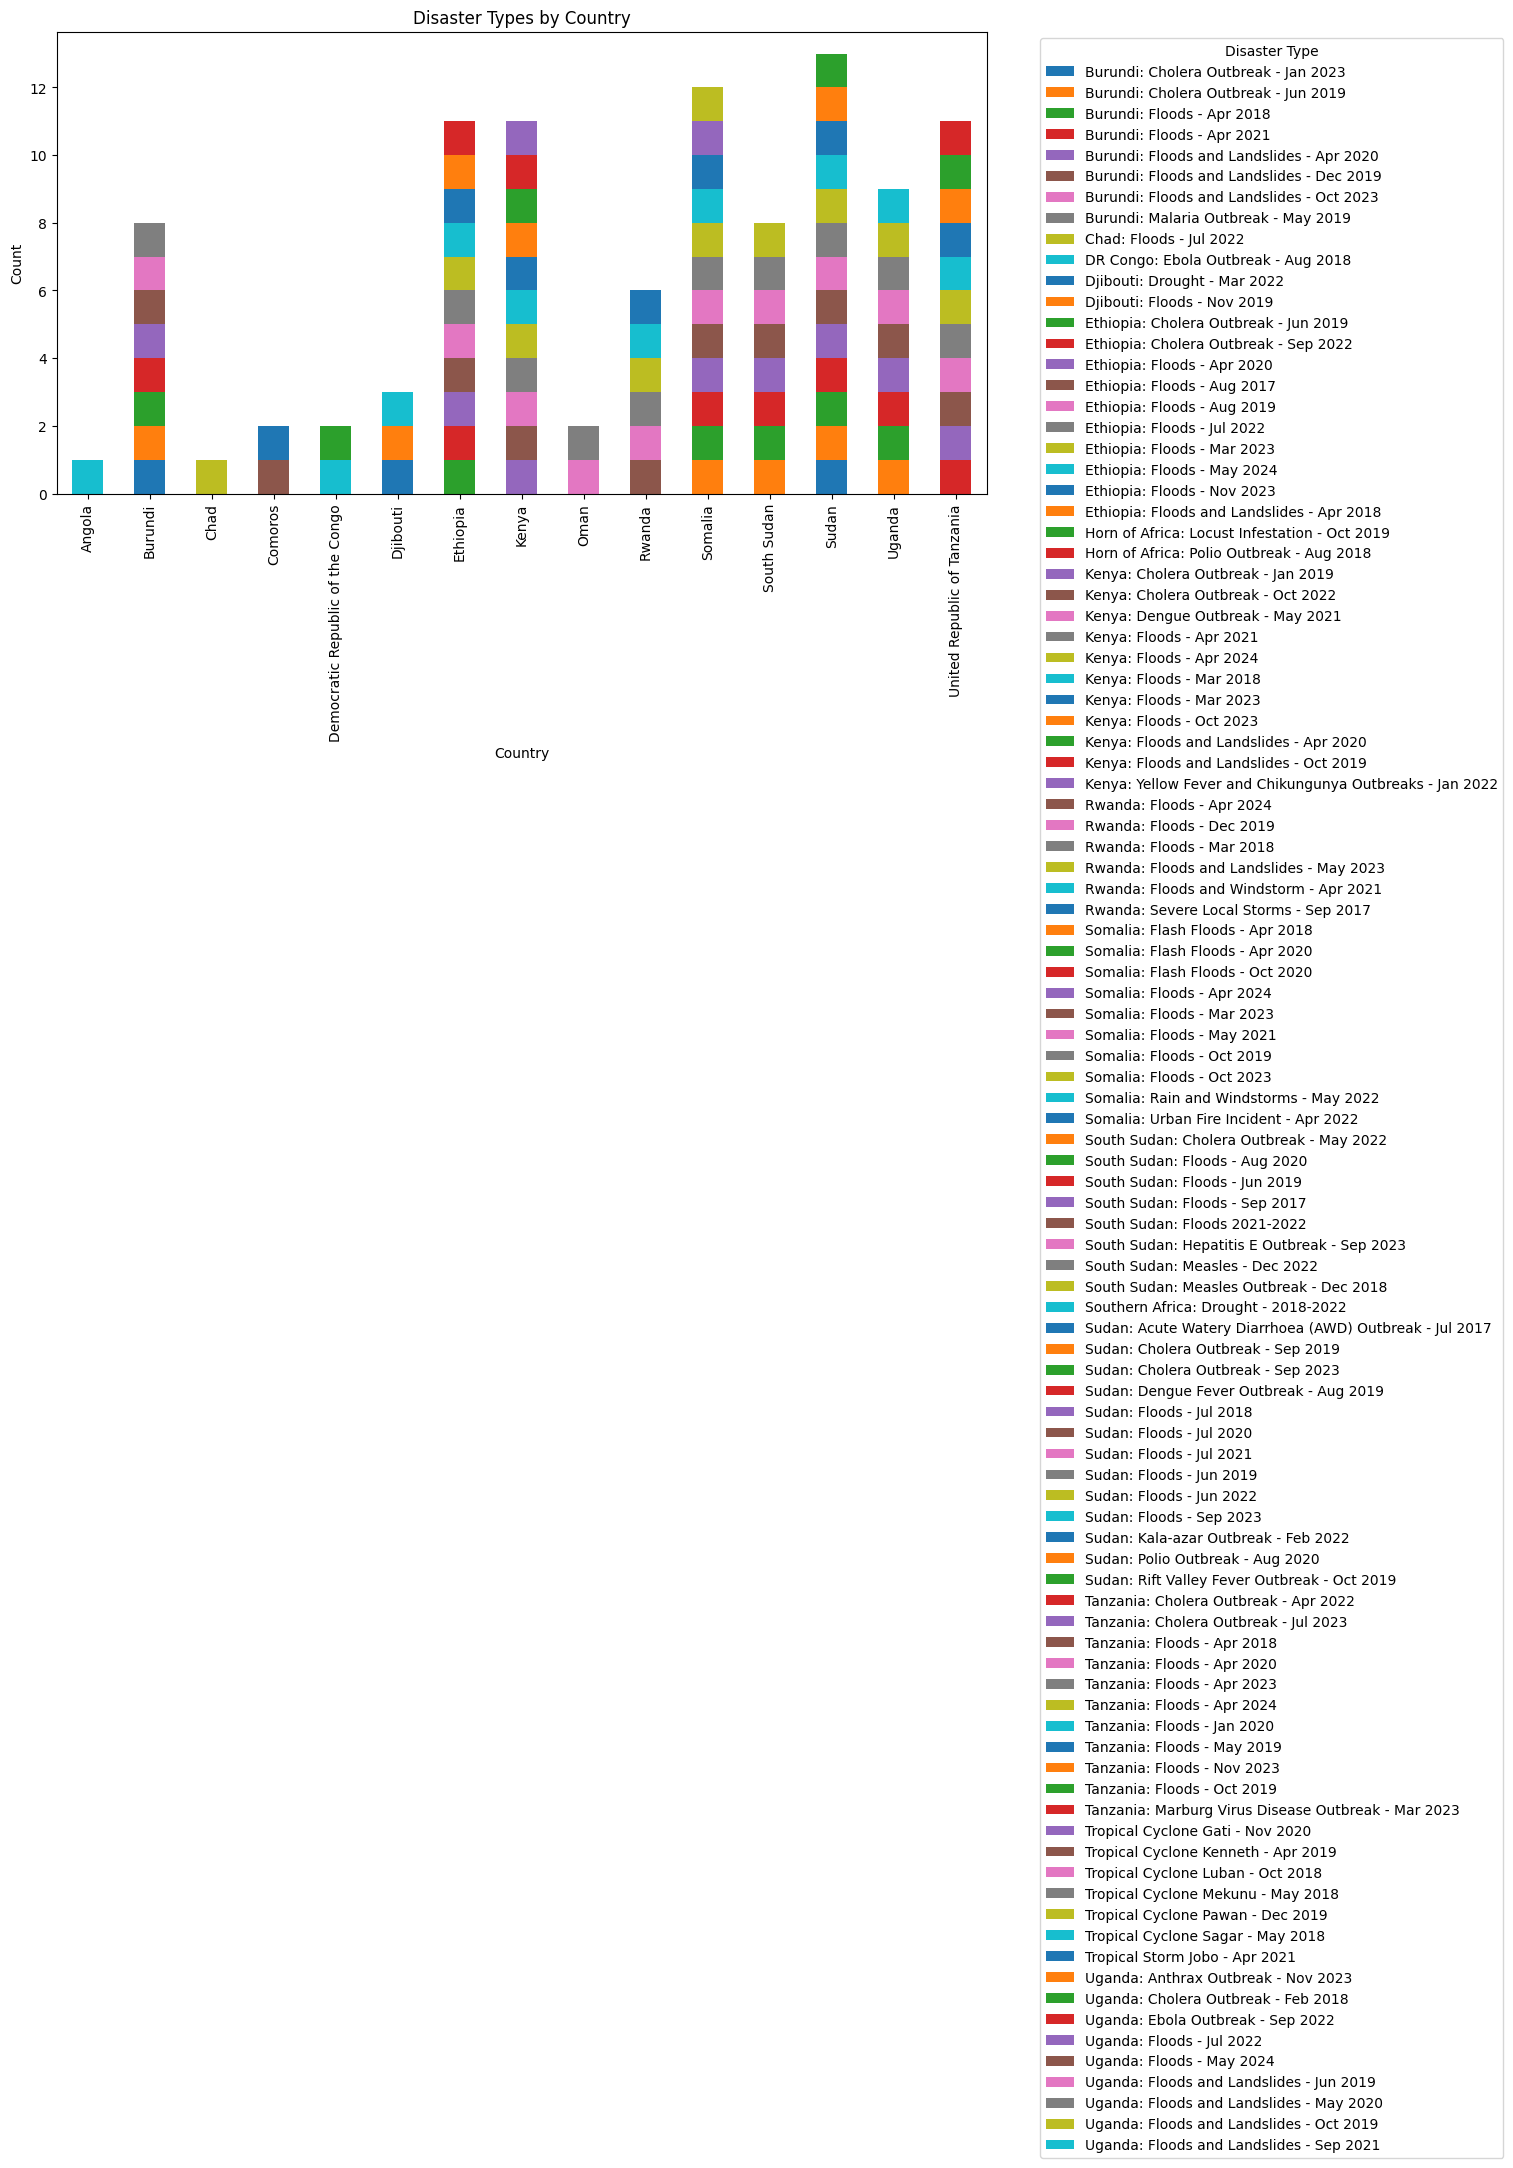

In [131]:
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded with the updated data

# Step 1: Check columns in merged_df
print("Columns in merged_df:", merged_df.columns)

# Step 2: Group by 'country' and 'disaster_type' and count occurrences
grouped = merged_df.groupby(['country', 'disaster_type']).size().unstack(fill_value=0)

# Step 3: Plotting
plt.figure(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Disaster Types by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Disaster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


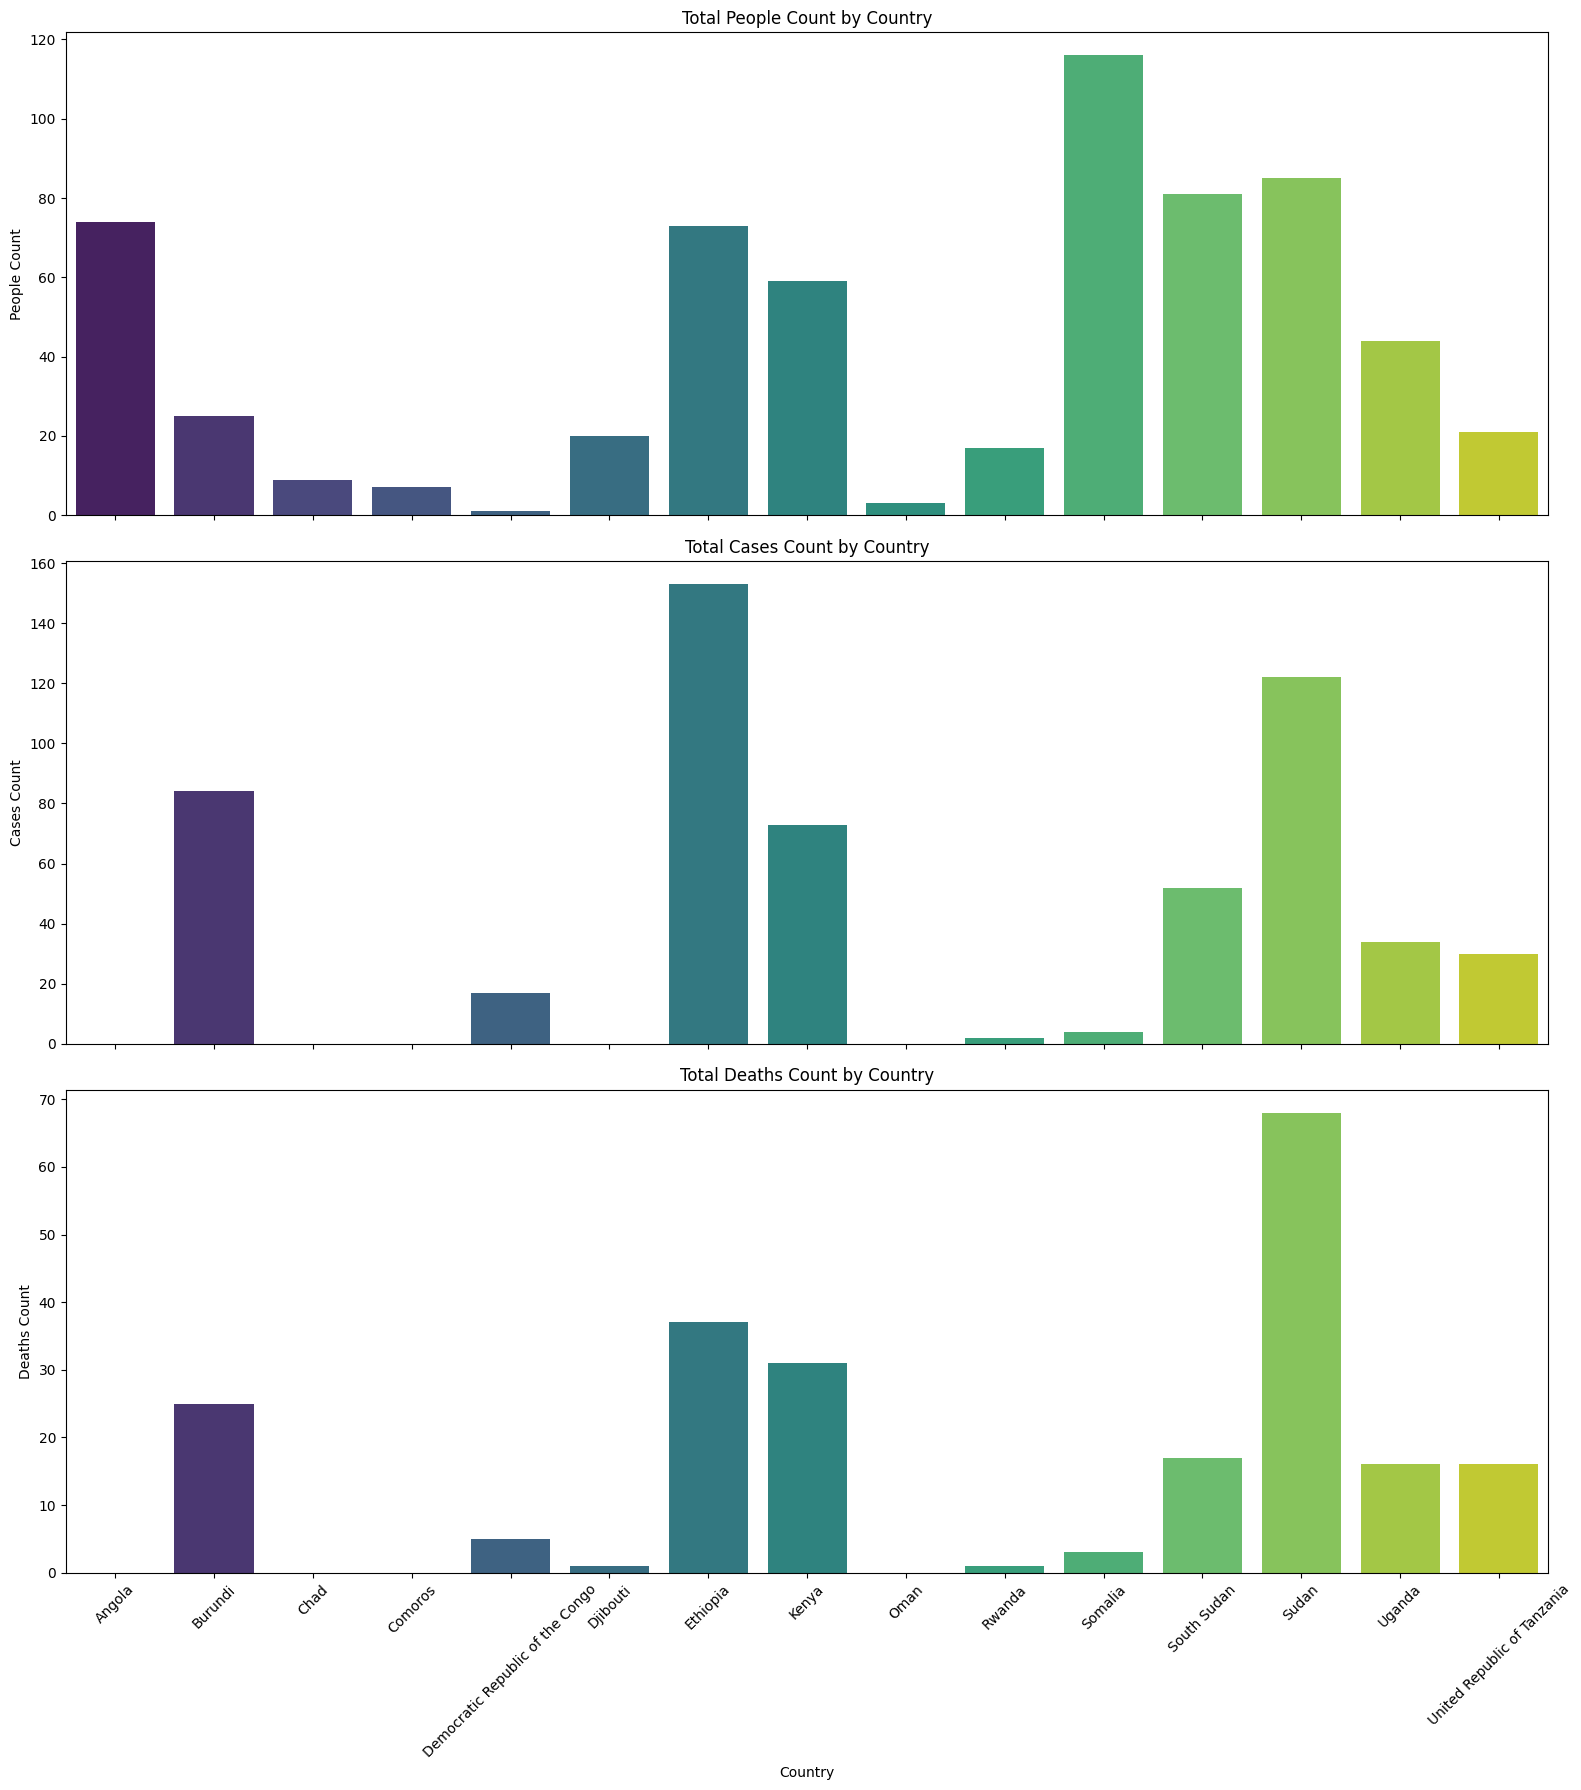

In [151]:
import seaborn as sns

# Step 1: Read the CSV file
file_path = '/content/processed_final_disaster_data.csv'
df = pd.read_csv(file_path)

# Step 2: Aggregate data by country
aggregated_df = df.groupby('country')[['people_count', 'cases_count', 'deaths_count']].sum().reset_index()

# Step 3: Plotting
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)

# Common parameters for bar plots
barplot_params = {
    'palette': 'viridis'
}

# Plotting people_count with hue
sns.barplot(ax=axes[0], x='country', y='people_count', data=aggregated_df, hue='country', **barplot_params)
axes[0].set_title('Total People Count by Country')
axes[0].set_xlabel('')
axes[0].set_ylabel('People Count')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
axes[0].legend().set_visible(False)  # Hide legend for better readability

# Plotting cases_count with hue
sns.barplot(ax=axes[1], x='country', y='cases_count', data=aggregated_df, hue='country', **barplot_params)
axes[1].set_title('Total Cases Count by Country')
axes[1].set_xlabel('')
axes[1].set_ylabel('Cases Count')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
axes[1].legend().set_visible(False)  # Hide legend for better readability

# Plotting deaths_count with hue
sns.barplot(ax=axes[2], x='country', y='deaths_count', data=aggregated_df, hue='country', **barplot_params)
axes[2].set_title('Total Deaths Count by Country')
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Deaths Count')
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout and show plot
plt.tight_layout()
plt.show()


feature engineering

##MODEL TRAINING

In [152]:
# Print a sample of the "disaster_type" column
print(df['disaster_type'].head())


0    Ethiopia: Floods - May 2024
1      Uganda: Floods - May 2024
2      Rwanda: Floods - Apr 2024
3    Tanzania: Floods - Apr 2024
4     Somalia: Floods - Apr 2024
Name: disaster_type, dtype: object


In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'cases_count' is your target variable, and other columns are features
# Drop columns that cannot be processed (e.g., 'date' if it's causing issues)
X = data.drop(['date', 'cases_count'], axis=1)
y = data['cases_count']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-hot encode categorical variables and scale numeric variables
categorical_cols = ['country']  # Assuming 'country' is categorical
numeric_cols = ['people_count', 'deaths_count']  # Numeric columns

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Scale numeric columns
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
    ],
    remainder='passthrough'  # Pass through any remaining columns
)

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a pipeline: Combine preprocessing with the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          52       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         0

    accuracy                           0.70        20
   macro avg       0.09      0.11      0.10        20
weighted avg       0.58      0.70      0.63        20


Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zer

Model Testing and Evaluation

In [154]:
from joblib import dump

# Save the trained model
model_filename = 'random_forest_model.joblib'
dump(rf_classifier, model_filename)

print("Model saved successfully as", model_filename)


Model saved successfully as random_forest_model.joblib


In [155]:
from joblib import load

# Load the saved model
loaded_model = load(model_filename)

In [ ]:
pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 6.6 MB/s eta 0:00:00
